Question Answering with 🤗
==============================


In this second task, we're going to stick to the 🤗 transformers library, but this time we're going to train a **generative question answering** model. We'll also stick to the **SQuAD** dataset.

## Setup
Let's double check that we have access to a GPU unit 🙏

If the following command errors, then you should change the environment in google colab settings to one with GPU:

In [2]:
!nvidia-smi

Thu Feb  2 20:34:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:5B:00.0 Off |                    0 |
| N/A   37C    P0    40W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# You should not need to set this if you're using google colab:
# %set_env PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python

Now let's go ahead and install all needed dependencies:

In [4]:
!pip install transformers sacremoses datasets evaluate sentencepiece torch matplotlib scikit-learn protobuf==3.20

We're going to load the SQuAD data again now. If for some reason it's not available, we should download it again as during the first task.

In [5]:
import json 

with open('train-v2.0.json') as f:
    train = json.load(f)["data"]
    
with open('dev-v2.0.json') as f:
    dev = json.load(f)["data"]

## Preparing data

We'll need to extract the data that interests us from the SQuAD dataset. For this task we're interested in extracting all the question-answer pairs.
Let's:
1. Create a list of dictionaries containing 'text' and 'labels' keys.
2. Each 'labels' entry should be an answer.
3. Let's format each field as follows: `question: <question> context: <context>`.

Here's an example of how one of our dictionaries could look after the transformation:
```
  {'text': 'question: What areas did Beyonce compete in when she was growing up? context: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
   'labels': 'singing and dancing'}],
```

#### ⭐️ Implement the extract_qa_pairs function based on the instructions above

<details>
    <summary>hint
    </summary>
    
```python
def extract_qa_pairs(dset):
    for topic in dset:
        for paragraph in topic["paragraphs"]:
            for qa in paragraph["qas"]:
                # Questions without answers are not helpful for us, so let's skip them:
                if qa['is_impossible']:
                    continue
                    
                answers = set(a["text"] for a in qa.get("answers", []))
                for a in answers:
                    yield {'text': f"question: {qa['question']} context: {paragraph['context']}", 'labels': a}
```
</details>

In [195]:
def extract_qa_pairs(dset):
    pass # 🤔

In [7]:
# TODO: Remove
def extract_qa_pairs(dset):
    for topic in dset:
        for paragraph in topic["paragraphs"]:
            for qa in paragraph["qas"]:
                # Questions without answers are not helpful for us, so let's skip them:
                if qa['is_impossible']:
                    continue
                    
                answers = set(a["text"] for a in qa.get("answers", []))
                for a in answers:
                    yield {'text': f"question: {qa['question']} context: {paragraph['context']}", 'labels': a}


In [8]:
train_qas = list(extract_qa_pairs(train))
dev_qas = list(extract_qa_pairs(dev))

In [9]:
len(train_qas) # 86821

86821

In [10]:
len(dev_qas) # 10279

10279

It's always a good practice to take some samples from the data to make sure we didn't make any silly mistakes (such as mixing up question and context fields or duplicating samples):

In [11]:
train_qas[:2], dev_qas[:2]

([{'text': 'question: When did Beyonce start becoming popular? context: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".',
   'labels': 'in the late 1990s'},
  {'text': 'question: What areas did Beyonce compete in when she was growing up? context: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singe

We can now pack this data to a 🤗 dataset and store it on our hard drive.

In [12]:
from datasets import Dataset, DatasetDict

train_qas_dset = Dataset.from_list(train_qas)
dev_qas_dset = Dataset.from_list(dev_qas)
datasets = DatasetDict({"train": train_qas_dset, "dev": dev_qas_dset})
datasets.save_to_disk("question-answering")

Saving the dataset (0/1 shards):   0%|          | 0/86821 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10279 [00:00<?, ? examples/s]

Let's see how our transformed dataset looks now:

In [13]:
print(datasets["train"][0]["text"])
print(datasets["train"][0]["labels"])
print(datasets["dev"][0]["text"])
print(datasets["dev"][0]["labels"])

question: When did Beyonce start becoming popular? context: Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
in the late 1990s
question: In what country is Normandy located? context: The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They

## Blind Tokenization

We're going to try to tokenize the inputs the same way as we did during the previous task.

In [197]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("t5-base")

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /net/ascratch/people/plgmrapacz/.cache/huggingface/hub/models--t5-base/snapshots/0db7e623bcaee2daf9b859a646637ea39bf016cd/config.json
Model config T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": 

There's a couple of differences we need to apply this time, since we're solving a different task. Namely, instead of having binary labels (0 and 1 for possible/impossible questions) we're having text results now. Text results have to be tokenized same as text inputs. 

The flow is almost the same, we just need to use the text_target parameter when calling the tokenizer:

In [198]:
def preprocess_function(examples):
    model_inputs = tokenizer(examples["text"])
    labels = tokenizer(text_target=examples["labels"])
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

Let's tokenize the datasets with the preprocess function we've just implemented

In [199]:
tokenized_datasets = datasets.map(preprocess_function, batched=True)

  0%|          | 0/87 [00:00<?, ?ba/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/11 [00:00<?, ?ba/s]

You should have received the following error:
> Token indices sequence length is longer than the specified maximum sequence length for this model (520 > 512). Running this sequence through the model will result in indexing errors

It seems like some of our inputs are too long and could lead to issues while handling the data. Let's try to see a bit better what's happening.

## Data-driven tokenization

Let's try to draw distributions of our input lengths after tokenization.

We're going to use matplotlib for plotting the histograms:

In [200]:
from matplotlib import pyplot as plt

Let's see how many tokens comprise each of our questions and answers

In [202]:
len_q_tokens = [len(x) for x in tokenized_datasets["train"]["input_ids"]]
len_a_tokens = [len(x) for x in tokenized_datasets["train"]["labels"]]

(array([1.4328e+04, 5.1067e+04, 1.6441e+04, 3.8510e+03, 8.4700e+02,
        1.8500e+02, 6.7000e+01, 1.6000e+01, 1.4000e+01, 5.0000e+00]),
 array([ 39. , 133.7, 228.4, 323.1, 417.8, 512.5, 607.2, 701.9, 796.6,
        891.3, 986. ]),
 <BarContainer object of 10 artists>)

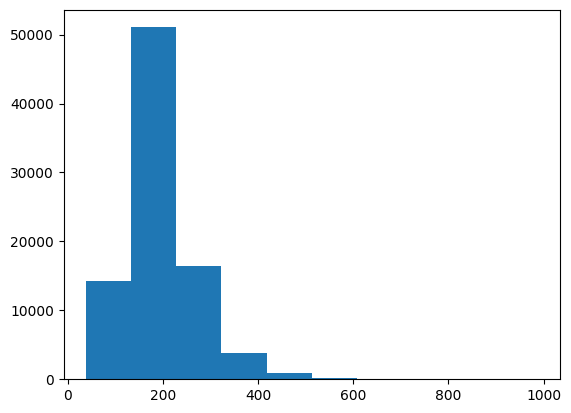

In [17]:
plt.hist(len_q_tokens)

(array([7.5108e+04, 7.9140e+03, 2.4550e+03, 8.8200e+02, 3.4400e+02,
        8.9000e+01, 1.1000e+01, 1.4000e+01, 2.0000e+00, 2.0000e+00]),
 array([ 2. ,  9.4, 16.8, 24.2, 31.6, 39. , 46.4, 53.8, 61.2, 68.6, 76. ]),
 <BarContainer object of 10 artists>)

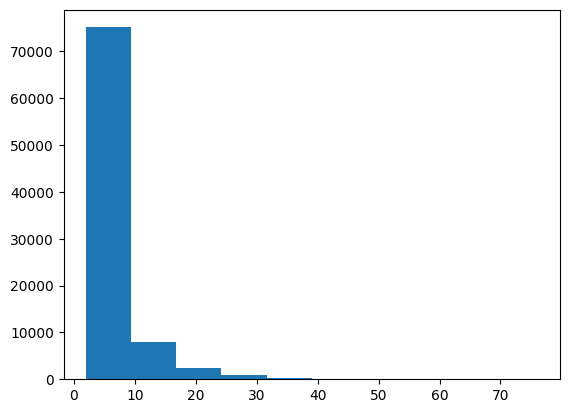

In [18]:
plt.hist(len_a_tokens)

We can see that indeed, there are some samples longer than 512. We should revisit our tokenization process and update it so that every question in our dataset will contain no more than 512 tokens.

In [203]:
def preprocess_function(examples):
    result = tokenizer(examples["text"], truncation=True, max_length=512)
    targets = tokenizer(
        examples["labels"], truncation=True, max_length=32, padding=True
    )
    input_ids = [
        [(l if l != tokenizer.pad_token_id else -100) for l in e] + [-100] * (32 - len(e))
        for e in targets["input_ids"]
    ]
    result["labels"] = input_ids
    return result

#### ⭐️ Apply the new preprocess_function

<details>
    <summary>hint
    </summary>
    
```python
tokenized_datasets = datasets.map(preprocess_function, batched=True)
```
</details>


In [205]:
tokenized_datasets = NotImplemented # 🤔

  0%|          | 0/87 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

In [163]:
print(tokenized_datasets["train"][0].keys())
print(tokenized_datasets["train"][0]["input_ids"])
print(tokenized_datasets["train"][0]["labels"])
print(len(tokenized_datasets["train"][0]["input_ids"]))
print(len(tokenized_datasets["train"][0]["labels"]))

dict_keys(['text', 'labels', 'input_ids', 'attention_mask'])
[822, 10, 366, 410, 493, 63, 14549, 456, 2852, 1012, 58, 2625, 10, 493, 63, 106, 75, 154, 3156, 7, 693, 8900, 965, 18, 6936, 449, 41, 87, 115, 23, 2, 354, 2, 29, 7, 15, 2, 87, 36, 15, 18, 476, 4170, 18, 8735, 61, 41, 7473, 1600, 6464, 15465, 61, 19, 46, 797, 7634, 6, 3, 21101, 6, 1368, 8211, 11, 15676, 5, 12896, 11, 3279, 16, 8018, 6, 2514, 6, 255, 3032, 16, 796, 8782, 11, 10410, 2259, 7, 38, 3, 9, 861, 6, 11, 4659, 12, 10393, 16, 8, 1480, 5541, 7, 38, 991, 7634, 13, 391, 184, 279, 3202, 18, 10739, 19344, 63, 31, 7, 9364, 5, 19607, 26, 57, 160, 2353, 6, 9762, 15, 210, 8900, 965, 6, 8, 563, 1632, 80, 13, 8, 296, 31, 7, 200, 18, 17556, 3202, 1637, 13, 66, 97, 5, 2940, 7102, 144, 302, 1509, 8, 1576, 13, 493, 63, 106, 75, 154, 31, 7, 5695, 2306, 6, 2744, 1304, 11937, 16, 2129, 3, 31210, 6, 84, 2127, 160, 38, 3, 9, 6729, 2377, 4388, 6, 4964, 874, 26596, 6580, 11, 4510, 8, 3259, 1976, 5396, 910, 381, 18, 782, 712, 7, 96, 254, 7275,

#### ⭐️ Plot length distributions of tokenized questions and answers for the fixed dataset
Questions to answer:
1. Did we resolve the question length issue?
2. Has anything else changed?

<details>
    <summary>hint
    </summary>

Histogram codes:
    
```python
input_ids = [len(x) for x in tokenized_datasets["train"]["input_ids"]]
plt.hist(input_ids)

labels = [len(x) for x in tokenized_datasets["train"]["labels"]]
plt.hist(labels)
```
    
    
<br/>    
Regarding the questions:
    
1. Yes, the issue should've been fixed.
2. We also padded all the answers so they are all of the same length (32).
</details>



In [207]:
## ⭐️ plot the question length distribution here

In [208]:
## ⭐️ plot the answer length distribution here

In [167]:
tokenized_datasets["train"]

Dataset({
    features: ['text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 86821
})

## Training

Now that our data has been tokenized, we can go ahead and set up all of our training pieces.

**About the model**


The QA problem will require us to use a different pre-trained model and a slightly different data preparation (which you've already noticed above). We're going to use the T5 model, which was trained on a **span corruption** task, meaning it was tasked with recovering fragments of texts - during the pretraining it was given texts which were missing some fragments and the model's goal was to 'recover' (i.e. regenerate) them. It was then also pretrained on a couple of downstream NLP tasks such as translation and question answering.

You can sit back and relax, there will be no more tasks until the training from now on. 

### Preparing the evaluation
Our evaluation code will consist of a couple of steps. This is because alongside numbers (metrics), we would also want to observe the actual responses our model is giving to the questions. This is why our 'compute_metrics' function will consist of the following:
1. Decoding a chosen answer from the model and printing it.
2. Computing standard metrics (bleu + exact match).
    - **note to self** - remember to talk about ^ during the labs
3. Computing average answer length of our model.

#### ⭐️ Bonus task ⭐️

There actually will be one more task for you. It should be fun, though 🙏
I mentioned that in the first part of the `compute_metrics` we're going to decode a chosen question. Your task is to pick a question you'd like to see our model improve on during the training (hint: try to pick a tough one).

You can see the questions with the following code:
```python
print("Question:", dev_qas_dset[<your chosen id>]["text"]) 
```
Once you're done, update the cell below with your id. The one I chose is 36.

In [213]:
CHOSEN_DEV_QUESTION_ID = 36

Now let's implement the `compute_metrics` function

In [212]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
import numpy as np
import evaluate

exact = evaluate.load("exact_match")
bleu = evaluate.load("bleu")


def compute_metrics(eval_pred):
    # Step 1: Decode the chosen answer
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    print("Question:", dev_qas_dset[CHOSEN_DEV_QUESTION_ID]["text"]) 
    print("Predicted:", decoded_preds[CHOSEN_DEV_QUESTION_ID])
    print("Expected:", decoded_labels[CHOSEN_DEV_QUESTION_ID])

    # Step 2: Compute bleu and exact match
    result = {
        "bleu": bleu.compute(predictions=decoded_preds, references=decoded_labels)["bleu"],
        **exact.compute(predictions=decoded_preds, references=decoded_labels),
    }

    # Step 3: Compute mean generated answer length
    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions
    ]
    result["gen_len"] = np.mean(prediction_lens)

    return result

### Training args

Let's prepare the training args now.

**Do not set FP16 to True**: this will likely cause the model to be unable to train. Some more details on this can be found in this thread: https://discuss.huggingface.co/t/t5-finetuning-tips/684/13

In [192]:
train_args = Seq2SeqTrainingArguments(
    output_dir='output_qa',
    do_train=True,
    do_eval=True,
    evaluation_strategy='steps',
    eval_steps=100,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,    
    learning_rate=1e-04,
    num_train_epochs=3, 
    logging_first_step=True,
    logging_strategy='steps',
    logging_steps=50,
    save_strategy='epoch',
    fp16=False, 
    optim='adafactor',
    eval_accumulation_steps=4,
    generation_max_length=32,
    predict_with_generate=True,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


The head for our model needs to be different this time as well:

In [193]:
from transformers import AutoModelForSeq2SeqLM
model = AutoModelForSeq2SeqLM.from_pretrained('t5-base')

loading configuration file config.json from cache at /net/ascratch/people/plgmrapacz/.cache/huggingface/hub/models--t5-base/snapshots/0db7e623bcaee2daf9b859a646637ea39bf016cd/config.json
Model config T5Config {
  "_name_or_path": "t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no

Let's build the final Trainer object now:

In [194]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Seq2SeqTrainer(
    model=model,
    args=arguments,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['dev'].select(range(512)),
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

### Let's go 🚀

In [215]:
%load_ext tensorboard
%tensorboard --logdir output/runs --host 0.0.0.0 --port=9002

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 9002 (pid 1757325), started 2:55:40 ago. (Use '!kill 1757325' to kill it.)

In [ ]:
trainer.train()

#### ⭐️ Bonus

If you've trained the model, you can evaluate it and compare it with another model, e.g. https://huggingface.co/distilbert-base-cased-distilled-squad (which is extractive, in this case)